In [1]:
import random
import numpy as np

import torch
import torch.nn as nn

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


In [2]:
OUTPUT_DIMS = 10
EMBED_DIMS = 64

EPOCHS = 6

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [3]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms

In [4]:
def into_3_chan_impl(img):
    return img.repeat(3, 1, 1)

In [5]:
into_3_chan = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(into_3_chan_impl)
])

train_data = FashionMNIST(
    root="FM/train",
    train=True,
    download=True,
    transform=into_3_chan,
)

test_data = FashionMNIST(
    root="FM/test",
    train=False,
    download=True,
    transform=into_3_chan
)

In [6]:
from torch.utils.data import DataLoader

dataloaders = {
    'train': DataLoader(
        dataset=train_data,
        batch_size=512,
        shuffle=True
    ),
    'test': DataLoader(
        dataset=test_data,
        batch_size=512,
        shuffle=False
    )
}

In [7]:
from torchvision.models import squeezenet1_1

class MyClassifier(nn.Module):
    def __init__(self, output_dims, embed_dims):
        super(MyClassifier, self).__init__()
        self.model = squeezenet1_1(pretrained=True, progress=True)

        for param in self.model.parameters():
            param.requires_grad = False

        self.fc1 = nn.Sequential(
            nn.Linear(1000, embed_dims),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(embed_dims, output_dims),
            nn.ReLU()
        )

    def embed(self, x):
        return self.fc1(self.model(x))

    def forward(self, x):
        embedded = self.embed(x)
        return self.fc2(embedded)

In [8]:
model = MyClassifier(OUTPUT_DIMS, EMBED_DIMS)
model.to(DEVICE)

MyClassifier(
  (model): SqueezeNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (exp

In [9]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-4)

In [10]:
from tqdm.notebook import tqdm, trange

loss_hist = {'train': [], 'test': []}
acc_hist = {'train': [], 'test': []}

prepare = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), inplace=True)

for epoch in trange(EPOCHS, desc="Epochs"):
    for phase in ['train', 'test']:
        dataloader = dataloaders[phase]

        if phase == 'train':
            model.train()
        elif phase == 'test':
            model.eval()

        curr_loss = 0.
        curr_acc = 0.

        for (X_batch, y_batch) in tqdm(dataloader, desc=f'Epoch: {epoch + 1}. Phase: {phase}'):
            prepare(X_batch)

            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(X_batch)

                loss_value = loss_func(y_pred, y_batch)
                y_pred_class = y_pred.argmax(dim=1)

                if phase == 'train':
                    loss_value.backward()
                    optimizer.step()

            curr_loss += loss_value.item()
            curr_acc += (y_pred_class == y_batch.data).float().mean().data.cpu().numpy()

        epoch_loss = curr_loss / len(dataloader)
        epoch_acc = curr_acc / len(dataloader)

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        loss_hist[phase].append(epoch_loss)
        acc_hist[phase].append(epoch_acc)


Epochs:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1. Phase: train:   0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 2.2835 Acc: 0.2206


Epoch: 1. Phase: test:   0%|          | 0/20 [00:00<?, ?it/s]

test Loss: 1.9073 Acc: 0.3671


Epoch: 2. Phase: train:   0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 1.9971 Acc: 0.3397


Epoch: 2. Phase: test:   0%|          | 0/20 [00:00<?, ?it/s]

test Loss: 1.8665 Acc: 0.3731


Epoch: 3. Phase: train:   0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 1.9243 Acc: 0.3609


Epoch: 3. Phase: test:   0%|          | 0/20 [00:00<?, ?it/s]

test Loss: 1.7485 Acc: 0.4116


Epoch: 4. Phase: train:   0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 1.7648 Acc: 0.4261


Epoch: 4. Phase: test:   0%|          | 0/20 [00:00<?, ?it/s]

test Loss: 1.5098 Acc: 0.5122


Epoch: 5. Phase: train:   0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 1.6256 Acc: 0.4730


Epoch: 5. Phase: test:   0%|          | 0/20 [00:00<?, ?it/s]

test Loss: 1.4740 Acc: 0.5186


Epoch: 6. Phase: train:   0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 1.5905 Acc: 0.4806


Epoch: 6. Phase: test:   0%|          | 0/20 [00:00<?, ?it/s]

test Loss: 1.4493 Acc: 0.5281


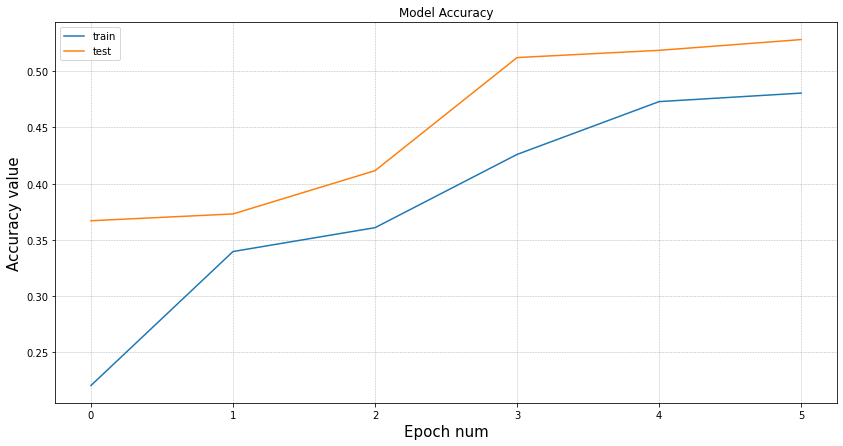

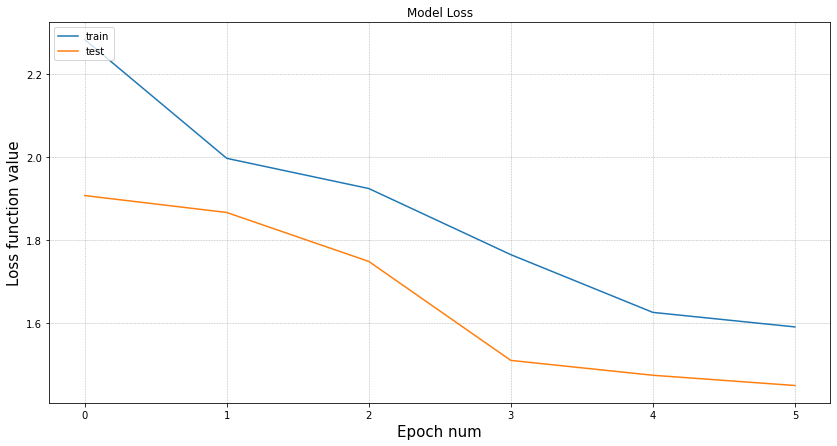

In [11]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc_hist.keys():
    plt.plot(acc_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

In [12]:
test_items = [test_data[i] for i in range(1000)]
xs, ys = zip(*test_items)

xs = torch.stack(xs)
xs = prepare(xs)
ys = np.array([*ys])
print("xs: ", xs.size(), ", ys: ", ys.shape)

xs:  torch.Size([1000, 3, 28, 28]) , ys:  (1000,)


In [13]:
embs = model.embed(xs.to(DEVICE)).cpu().detach().numpy()
embs.shape

(1000, 64)

In [14]:
import umap

reducer = umap.UMAP(n_neighbors=40, min_dist=0.2, random_state=0, n_jobs=6)
points = reducer.fit_transform(embs)
points.shape

(1000, 2)

In [15]:
def draw_clusters(x, y, cols):
    plt.figure(figsize=(12, 12))
    plt.scatter(x, y,
                c=cols, edgecolor='none',
                cmap=plt.cm.get_cmap('nipy_spectral', OUTPUT_DIMS))
    plt.colorbar()
    plt.show()

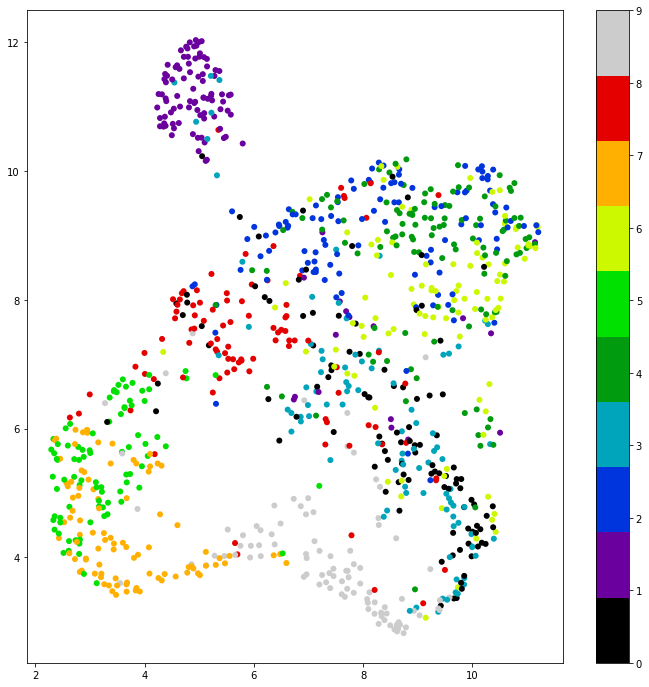

In [16]:
import matplotlib.pyplot as plt

draw_clusters(points[:, 0], points[:, 1], ys)

In [17]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [18]:
writer.add_embedding(embs,
                     metadata=ys,
                     label_img=xs)
writer.close()